I had a friend ask me to help answer some questions he had related to video game critic ratings. He was in a fantasy-football style league, but instead of players it was video games! As games came out during the year, the participants gained points if the games they selected performed well on metacritic.com or if they successfully counterpicked someone else's games which did poorly. He wanted to know if there was a data-driven way to help improve his selections and turned to me. He wanted to know three questions:

#### Q1. How well can you predict a good or bad game?
 
#### Q2. How do sequels compare to original games?

#### Q3. How much does time between games in the same franchise affect their change in score from previous game?

Thankfully, I found a useful dataset online for just this type of problem: https://www.kaggle.com/code/jaymin151617/scraping-metacritic-website-for-best-games

In [2]:
## data management
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats
from collections import Counter
import math
import random
#visual
import matplotlib.pyplot as plt
import seaborn as sns
#modeling
from sklearn.linear_model import LinearRegression, Lasso,LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# specific functions
from fantasy_funcs import *
import warnings
import pickle


## Data cleaning


In [4]:
data_df = pd.read_csv('games-data.csv',parse_dates = ['r-date'])

## make any new columns that can be made already
data_df.rename(columns = {'r-date': 'releaseD'}, inplace = True)
data_df['year'] = data_df['releaseD'].dt.year
data_df['month'] = data_df['releaseD'].dt.month

data_df['quarter'] = np.ceil(data_df['month']/3) # quarter of release date
data_df.head()


,name,platform,releaseD,score,user score,developer,genre,players,critics,users,year,month,quarter
0,The Legend of Zelda: Ocarina of Time,Nintendo64,1998-11-23,99,9.1,Nintendo,"Action Adventure,Fantasy",1 Player,22,5749,1998,11,4.0
1,Tony Hawk's Pro Skater 2,PlayStation,2000-09-20,98,7.4,NeversoftEntertainment,"Sports,Alternative,Skateboarding",1-2,19,647,2000,9,3.0
2,Grand Theft Auto IV,PlayStation3,2008-04-29,98,7.6,RockstarNorth,"Action Adventure,Modern,Modern,Open-World",1 Player,64,3806,2008,4,2.0
3,SoulCalibur,Dreamcast,1999-09-08,98,8.5,Namco,"Action,Fighting,3D",1-2,24,324,1999,9,3.0
4,Grand Theft Auto IV,Xbox360,2008-04-29,98,7.9,RockstarNorth,"Action Adventure,Modern,Modern,Open-World",1 Player,86,3364,2008,4,2.0


### Clustering algorthm for sequels
The dataset does not give me all the information I need regarding sequels however I do have the titles, release dates, and developers for each game. I've decided to design a clustering algorithm that will group games from the same developers as a 'best guess' grouping. This will help also determine if different franchises have different scores even if they have the same developers. An example of clustering is at the bottom of the notebook

1. How many games does a developer have [studio_size] and their average score [ave_studio_score].
2. Cluster by different titles for each studio [in_cluster][cluster_num][ave_cluster_score][cluster_size][cluster_deviation]. For example, Zelda may score better than nintendos typically so I don't want those scores to necessarily be in the same category.
3. Where is this in the franchise? The first or a later one [franchiseNum]. What is the time between franchise numbers [time_between] and what was the score difference [score_delta].
4. What is the time between games out a studio in general [studio_time_between] and what is the score difference [studio_delta]

In [90]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

data_df[['ave_cluster_score','cluster_num','in_cluster','ave_studio_score','studio_size','cluster_size','cluster_deviation','franchiseNum','time_between','studio_time_between','score_delta','studio_delta']] = (
    np.zeros((data_df.shape[0],12)))


platforms = data_df.platform.unique().tolist() # will be used in the cluster algorithm

all_devNams = data_df['developer'].unique().tolist()# loop through all developers

for dev in range(len(all_devNams)):
    devnam = all_devNams[dev] 
    names = data_df[data_df['developer'] == devnam]['name'].tolist()# get the list of games for this developer
    # assign studio size and studio score
    data_df.loc[data_df['developer'] == devnam,'studio_size'] = len(names)
    data_df.loc[data_df['developer'] == devnam,'ave_studio_score'] = data_df.loc[data_df['developer'] == devnam,'score'].mean()
    studio_df = data_df[(data_df['developer'] == devnam)].sort_values('releaseD') # sort the cluster by release Date
    for h in range(1,studio_df.shape[0]):
        data_df.iloc[studio_df.index[h], data_df.columns == 'studio_time_between'] = (data_df['releaseD'][studio_df.index[h]] - data_df['releaseD'][studio_df.index[h-1]]).days # time difference between the last titles
        data_df.iloc[studio_df.index[h], data_df.columns == 'studio_delta'] = (data_df['score'][studio_df.index[h]] - data_df['score'][studio_df.index[h-1]]) # score difference between the last title
    # now lets look at studios that have more than one game out
    if len(names) > 2:
        clusters,unclustered = generate_clusters(names, platforms=platforms) # run clustering algorithm in the fantasy_funcs file
        for clstnum in range(len(clusters)):
            for nm in clusters[clstnum]:
                checkVal = (data_df['developer'] == devnam) & (data_df['cluster_num'] == clstnum+ 1)
                data_df.loc[(data_df['name'] == names[nm]) & (data_df['developer'] == devnam), ['cluster_num','in_cluster','cluster_size']] = [clstnum + 1,1,len(clusters[clstnum])]
            
            data_df.loc[checkVal, ['ave_cluster_score','cluster_deviation']] = [data_df.loc[checkVal ,'score'].mean(), data_df.loc[checkVal ,'score'].std()] #assign average standard deviation

            # lets try to number them by where they are in the franchise
            clust_df = data_df[(data_df['developer'] == devnam) & (data_df['cluster_num'] == clstnum + 1)].sort_values('releaseD') # sort the cluster by release Date
            for g in range(1,clust_df.shape[0]): # for each one but skip the first one
                data_df.iloc[clust_df.index[g], data_df.columns == 'franchiseNum'] = g+1 # find where it is in the data_df and index the franchise number
                data_df.iloc[clust_df.index[g], data_df.columns == 'time_between'] = (data_df['releaseD'][clust_df.index[g]] - data_df['releaseD'][clust_df.index[g-1]]).days
                data_df.iloc[clust_df.index[g], data_df.columns == 'score_delta'] = (data_df['score'][clust_df.index[g]] - data_df['score'][clust_df.index[g-1]])
                
## assign the average to the rows that do not have a cluster 
data_df.loc[(data_df['ave_cluster_score'] == 0), 'ave_cluster_score'] = data_df[data_df['ave_cluster_score'] > 0]['ave_cluster_score'].mean()
data_df['majdev'] = data_df['developer'] # limit the developers to major/minor
data_df.loc[data_df['studio_size'] < 5, 'majdev'] = 'ind' # if they have less than 5 games they are a small developer
print('done!')

done!



Now you can see we have a much larger dataset

In [8]:
data_df.head()

,name,platform,releaseD,score,user score,developer,genre,players,critics,users,...,cluster_num,ave_cluster_score,cluster_size,cluster_deviation,franchiseNum,time_between,studio_time_between,score_delta,studio_delta,majdev
0,The Legend of Zelda: Ocarina of Time,Nintendo64,1998-11-23,99,9.1,Nintendo,"Action Adventure,Fantasy",1 Player,22,5749,...,1.0,90.529412,17.0,7.323913,0.0,0.0,54.0,0.0,14.0,Nintendo
1,Tony Hawk's Pro Skater 2,PlayStation,2000-09-20,98,7.4,NeversoftEntertainment,"Sports,Alternative,Skateboarding",1-2,19,647,...,1.0,84.400000,25.0,8.326664,2.0,386.0,21.0,6.0,11.0,NeversoftEntertainment
2,Grand Theft Auto IV,PlayStation3,2008-04-29,98,7.6,RockstarNorth,"Action Adventure,Modern,Modern,Open-World",1 Player,64,3806,...,1.0,94.062500,16.0,4.596647,7.0,1057.0,0.0,5.0,0.0,RockstarNorth
3,SoulCalibur,Dreamcast,1999-09-08,98,8.5,Namco,"Action,Fighting,3D",1-2,24,324,...,1.0,92.200000,5.0,4.266146,0.0,0.0,130.0,0.0,10.0,Namco
4,Grand Theft Auto IV,Xbox360,2008-04-29,98,7.9,RockstarNorth,"Action Adventure,Modern,Modern,Open-World",1 Player,86,3364,...,1.0,94.062500,16.0,4.596647,8.0,0.0,1057.0,0.0,5.0,RockstarNorth


# Q1: How well can you predict a good or bad game?
I was able to build a regression model that explained 67% of the variance in the dataset. I used a train/test lasso regression for features selection to determine what are the most important factors for considering whether or not to pick a game.





### 1. Formatting the data
Because the data has a lot of categorical variables (including multiple genres and developers) I'm going to turn them into one-hot coded variables. 


In [21]:
## Formatting the data
model_df = data_df

# now how do we want to limit the data?

model_df = model_df[model_df['score']> 40] # lets get rid of the ones at the very bottom. Let's not include games that score less than 40
model_df = model_df[model_df['year'] > 2010 ]# lets get rid of any that are before the year 2010
model_df.reset_index(inplace = True)


#lets break down all the genres which are a list inside the column 'genre'
allgenres = [x for x in model_df['genre']]
allgenres[1]
unique_genres = []
for i in range(len(allgenres)):
    each = allgenres[i].split(',')
    for j in each:
        if j not in (unique_genres):
            unique_genres.append(j)

# now lets turn them into 1hot coding
hotOneGenres = np.zeros([len(model_df), len(unique_genres)])

for i in range(len(allgenres)):
    each = allgenres[i].split(',')
    for j in each:
        hotOneGenres[i, unique_genres.index(j)] = 1

dummy_developer = pd.get_dummies(model_df['majdev'])
dummy_platform = pd.get_dummies(model_df['platform'])
dummy_month = pd.get_dummies(model_df['quarter'])
dummy_month.rename(columns = {1.0: 'Q1', 2.0: 'Q2', 3.0: 'Q3', 4.0: 'Q4'}, inplace = True)

#alldata = np.concatenate((hotOneGenres, hotOnePlatform, data_df[['year']],data_df[['month']]), axis = 1)
alldata = pd.concat((model_df[['ave_studio_score']],model_df[['studio_size']], model_df[['year']],model_df[['franchiseNum']], model_df[['cluster_size']],model_df[['ave_cluster_score']], model_df[['in_cluster']], dummy_month, pd.DataFrame(hotOneGenres, columns = unique_genres), dummy_developer, dummy_platform), axis = 1)#


### 2. Split the data and build the model
I'm going to split the model into train/test sets I'll be using to build the model


In [24]:
X_train, X_test, y_train, y_test = train_test_split(alldata, model_df[['score']], test_size=0.25) # split into train/test dataset
to_norm = ['ave_studio_score', 'studio_size','year', 'franchiseNum', 'ave_cluster_score'] #regressors to be demeaned

scaler = StandardScaler().fit(X_train[to_norm]) # standardize the regressors
X_test[to_norm] = scaler.transform(X_test[to_norm])
X_train[to_norm] = scaler.transform(X_train[to_norm])


### 3. Use a CV lasso model to do feature selection
The lasso model will force beta values towards 0 which can then be excluded from the model. Because we have several hundred possible variables, I want to reduce the variables to the most useful ones


In [27]:

# use LassoCV (cross validation) to determine alpha
model = LassoCV()

# Fit model
model.fit(X_train, y_train['score'].to_list())

lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train['score'].to_list())

# lets figure out what the percentage of variance explained ( want this to be higher up to 1)
print('R^2 training', round(lasso_best.score(X_train, y_train)*100, 2))
print('R^2 testing', round(lasso_best.score(X_test, y_test)*100, 2))

#What is the mean squared error (want this to be smaller)
pred_train = lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

pred_test = lasso_best.predict(X_test)
mse_test =mean_squared_error(y_test, pred_test)
print('MSE test set', round(mse_test, 2))

R^2 training 67.5
R^2 testing 66.47
MSE training set 34.21
MSE test set 36.23


Let's do variable selection and only include the variables that the survived the model



In [30]:
paired = list(zip(lasso_best.coef_, alldata)) # Let's get a list of the regressors and their coefficients
relevant = [x for x in paired if (x[0] > 0.001) | (x[0] < -0.001)] #regressors that survived the lasso

#reg = LinearRegression().fit(alldata,data_df[['score']])
predicted_score = lasso_best.predict(X_test)

corrval = stats.pearsonr(predicted_score, y_test['score'].to_numpy())


Text(0.5, 1.0, 'Actual vs Predicted, LassoCV Corr= 0.815 p =0.0')

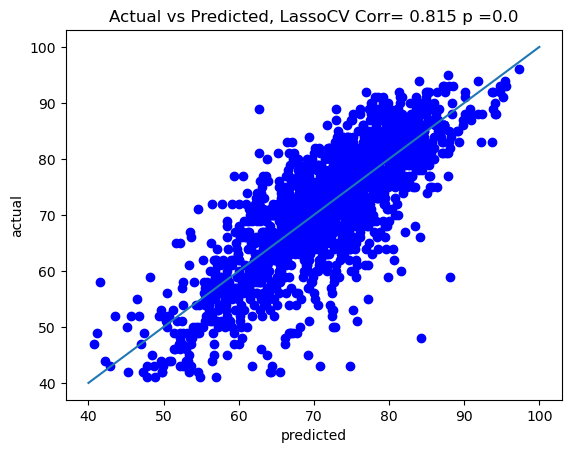

In [32]:
## lets see how correlated the actual vs predicted scores are 
f, ax = plt.subplots()

plt.scatter(predicted_score,y_test[['score']],  color = 'blue')
plt.plot([40,100],[40,100], '-')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Actual vs Predicted, LassoCV Corr= ' + str(np.round(corrval[0],3)) + ' p =' + str(np.round(corrval[1],3)))

### 4. Rerun a regular model with the remaining regressors and test how it fits on the testing data

In [35]:
reg = LinearRegression()
reg.fit(X_train[np.array(relevant)[:,1]], y_train['score'])

pred_test = reg.predict(X_test[np.array(relevant)[:,1]])
mse_test =mean_squared_error(y_test, pred_test)

print('MSE test set', round(mse_test, 2))
print('R^2 testing', round(reg.score(X_test[np.array(relevant)[:,1]], y_test)*100, 2))

MSE test set 36.3
R^2 testing 66.41


In [37]:
#save final regression model
pickle.dump(reg, open('regressor_model.save', 'wb'))

### So what are the most important variables?



In [40]:
imp_var_df = pd.DataFrame(relevant, columns = ['beta weight', 'variable']) # turn the regressors into a data fram
imp_var_df['abs weight'] = np.abs(imp_var_df['beta weight']) # get an absolute beta weight for ordering
imp_var_df.sort_values('abs weight', ascending=False, inplace = True,ignore_index=True) # sort by the absolute value

for rws in range(imp_var_df.shape[0]):
    print(imp_var_df['variable'][rws] + ' weight: ' + str(round(imp_var_df['beta weight'][rws],3))) # print out the relevant variables

ave_studio_score weight: 6.194
EASports weight: -3.427
ave_cluster_score weight: 3.339
OmegaForce weight: 2.237
in_cluster weight: 1.424
franchiseNum weight: -1.337
Ubisoft weight: 1.15
3DS weight: -1.043
Arcade weight: -0.757
Compilation weight: 0.663
Real-Time weight: -0.599
Fighting weight: 0.525
ind weight: 0.461
General weight: -0.431
year weight: 0.412
Action RPG weight: -0.391
PlayStation4 weight: -0.363
Nintendo weight: -0.324
PC weight: 0.279
Q1 weight: -0.255
Modern weight: -0.197
2D weight: 0.194
Fantasy weight: 0.175
Q2 weight: -0.174
Puzzle weight: 0.162
cluster_size weight: 0.127
studio_size weight: -0.101
Q4 weight: 0.095
Adventure weight: 0.071
Switch weight: -0.054
Miscellaneous weight: 0.048
Q3 weight: 0.028
Soccer weight: 0.013


# Q2: How do sequels compare to original games?
The number in a franchise is not related to the score of the game. 

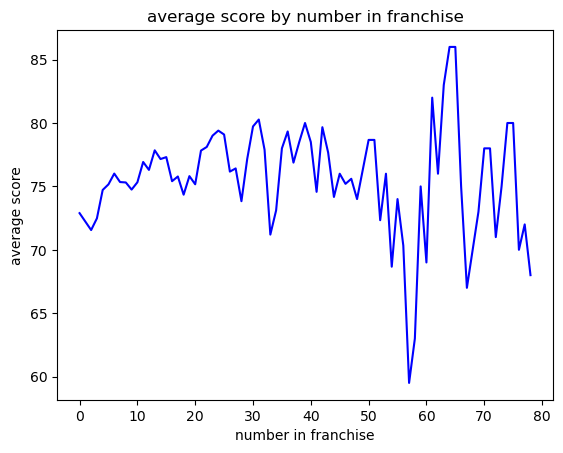

In [43]:
## Formatting the data
sequel_df = data_df[data_df['in_cluster'] == 1]

sequel_df = sequel_df[sequel_df['score']> 40] # lets get rid of the ones at the very bottom. Let's not include games that score less than 40
sequel_df = sequel_df[sequel_df['year'] > 2010 ]# lets get rid of any that are before the year 2010
sequel_df.reset_index(inplace = True)



average_sequel = pd.pivot_table(sequel_df, values = 'score',columns = 'franchiseNum',aggfunc = 'mean')

fig, ax = plt.subplots()

plt.plot(average_sequel.columns.to_numpy(), average_sequel.to_numpy()[0], 'b')
plt.title('average score by number in franchise')
plt.xlabel('number in franchise')
plt.ylabel('average score')
plt.show()



There is huge variability here! I'm assuming that some of it is due to the rarity of later sequels so lets see how many there are in all these bins and lets get rid of ones that have less that 30 examples in it

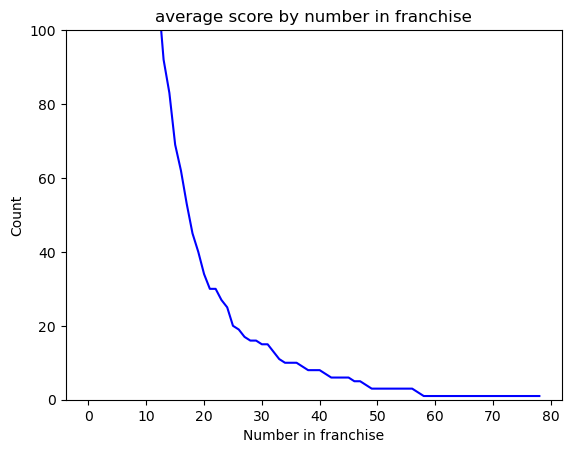

In [46]:
## Formatting the data
sequel_df = data_df[data_df['in_cluster'] == 1]

average_sequel = pd.pivot_table(sequel_df, values = 'score',columns = 'franchiseNum',aggfunc = 'count')

fig, ax = plt.subplots()

plt.plot(average_sequel.columns.to_numpy(), average_sequel.to_numpy()[0], 'b')
plt.ylim([0,100]) # limited so we can see the limit here
plt.title('average score by number in franchise')
plt.xlabel('Number in franchise')
plt.ylabel('Count')
plt.show()


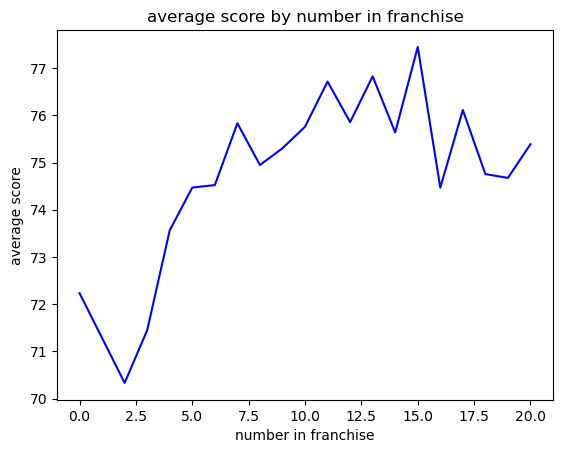

In [48]:
max_included = average_sequel.columns[average_sequel.iloc[0]> 30].max() # this is the final sequel that will have its own category. Anything after this will just get 15
sequel_df.loc[sequel_df['franchiseNum'] >= max_included, 'franchiseNum'] = max_included

average_sequel = pd.pivot_table(sequel_df, values = 'score', columns = 'franchiseNum', aggfunc = {'score': ['mean','count','std']})

fig, ax = plt.subplots()

plt.plot(average_sequel.columns.to_list(), average_sequel.loc['mean'].to_list(), 'b')
plt.title('average score by number in franchise')
plt.xlabel('number in franchise')
plt.ylabel('average score')
plt.show()

MSE test set 133.73
R^2 testing 1.46


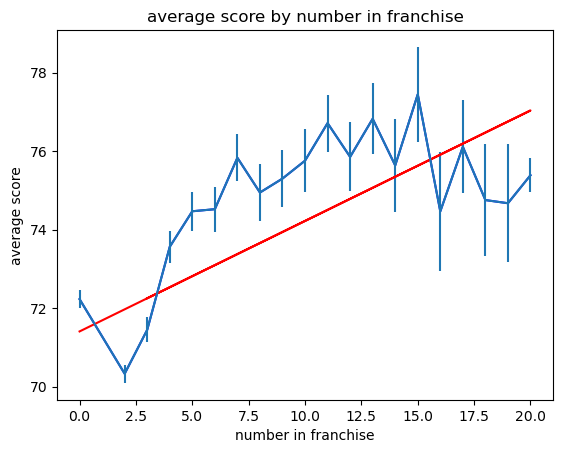

In [50]:
reg = LinearRegression()
xval = sequel_df[['franchiseNum']]
yval = sequel_df[['score']]
reg.fit(xval,yval)

pred_test = reg.predict(xval)
mse_test =mean_squared_error(yval,pred_test)
print('MSE test set', round(mse_test, 2))
print('R^2 testing', round(reg.score(xval, yval)*100, 2))


fig, ax = plt.subplots()

plt.plot(average_sequel.columns.to_list(), average_sequel.loc['mean'].to_list(), 'b')
plt.errorbar(average_sequel.columns.to_list(), average_sequel.loc['mean'].to_list(),[x/(np.sqrt(y-1)) for x, y in zip(average_sequel.loc['std'], average_sequel.loc['count'])])
plt.title('average score by number in franchise')
plt.xlabel('number in franchise')
plt.ylabel('average score')

plt.plot(xval, pred_test, 'r')

plt.show()



Given how low the R^2 this is. This doesn't look to me like the average score by franchise is really predictive at least not linearly


# Q3: How much does time between games in the same company/franchise affect their change in score from previous game?
The time between games does not effect the score of the next games

MSE test set 97.49
R^2 testing 0.03


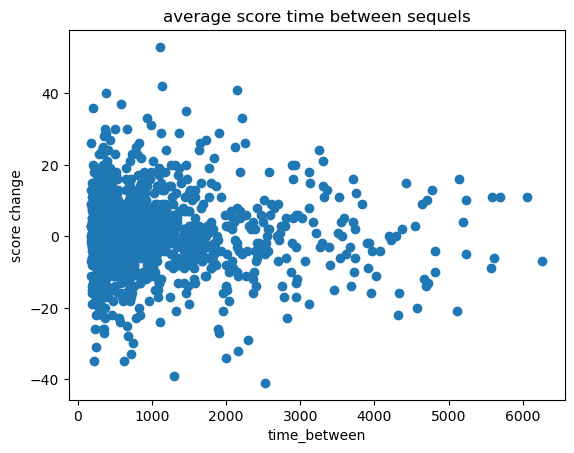

In [56]:
# lets get rid of the first one in the franchise, any that aren't in a franchise at all
# additionally, I'm going to limit it by greater than a half a year because I suspect less than 6 months are either rereleases or were already in development before the previous one published
only_sequel_df = data_df[(data_df['franchiseNum'] >1 ) & (data_df['in_cluster'] == 1)& (data_df['time_between'] > 180)]
only_sequel_df = only_sequel_df[only_sequel_df['score']> 40] # lets get rid of the ones at the very bottom. Let's not include games that score less than 40
only_sequel_df = only_sequel_df[only_sequel_df['year'] > 2010 ]# lets get rid of any that are before the year 2010
only_sequel_df.reset_index(inplace = True)

reg = LinearRegression()
xval = only_sequel_df[['time_between']]
yval = only_sequel_df[['score_delta']]
reg.fit(xval,yval)

pred_test = reg.predict(xval)
mse_test =mean_squared_error(yval,pred_test)
print('MSE test set', round(mse_test, 2))
print('R^2 testing', round(reg.score(xval, yval)*100, 2))


fig, ax = plt.subplots()

plt.scatter(xval, yval)
plt.title('average score time between sequels')
plt.xlabel('time_between')
plt.ylabel('score change')

plt.show()


MSE test set 115.26
R^2 testing 0.12


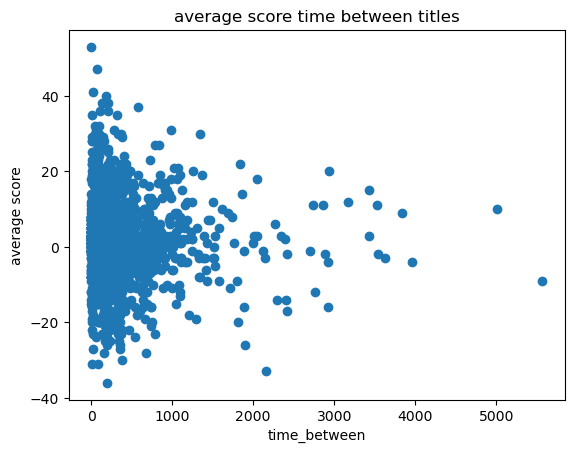

In [58]:
# lets get rid of the first one in the franchise, any that aren't in a franchise at all
# additionally, I'm going to limit it by greater than a half a year because I suspect less than 6 months are either rereleases or were already in development before the previous one published
only_sequel_df = data_df[(data_df['time_between'] > 180)]
only_sequel_df = only_sequel_df[only_sequel_df['score']> 40] # lets get rid of the ones at the very bottom. Let's not include games that score less than 40
only_sequel_df = only_sequel_df[only_sequel_df['year'] > 2010 ]# lets get rid of any that are before the year 2010
only_sequel_df.reset_index(inplace = True)

reg = LinearRegression()
xval = only_sequel_df[['studio_time_between']]
yval = only_sequel_df[['studio_delta']]
reg.fit(xval,yval)

pred_test = reg.predict(xval)
mse_test =mean_squared_error(yval,pred_test)
print('MSE test set', round(mse_test, 2))
print('R^2 testing', round(reg.score(xval, yval)*100, 2))


fig, ax = plt.subplots()

plt.scatter(xval, yval)
plt.title('average score time between titles')
plt.xlabel('time_between')
plt.ylabel('average score')

plt.show()


Q3A: Time between games from a studio or sequels in a series is not predictive of scores

# Q0: What is the distribution of scores? How is this affected by time of year? Has this changed over the years?
The number of games has greatly increased by year but the mean has remain consistent since the 2000s. However as the number of games per year has increased the distribution of games per month has shifted away from games coming out at the end of the year and now is more evenly distributed throughout the year 

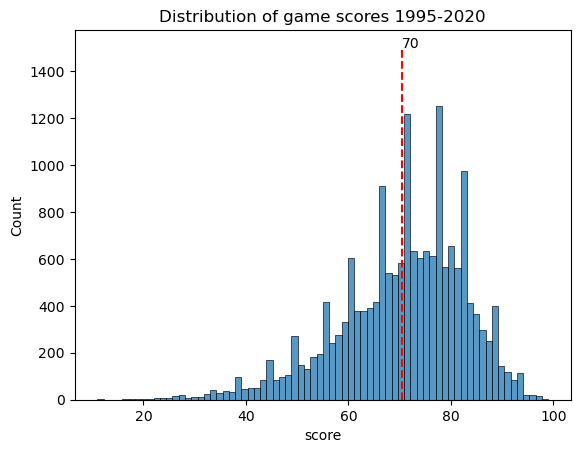

In [62]:
meanval = data_df['score'].mean()

fig, ax = plt.subplots()

sns.histplot(data=data_df, x='score')
plt.plot([meanval, meanval], [0, 1500], linestyle = '--', color = 'red')
plt.text(meanval, 1500, str(round(meanval)))
plt.title('Distribution of game scores 1995-2020')
plt.show()



### Next lets consider how the distribution of games might change by months of the year

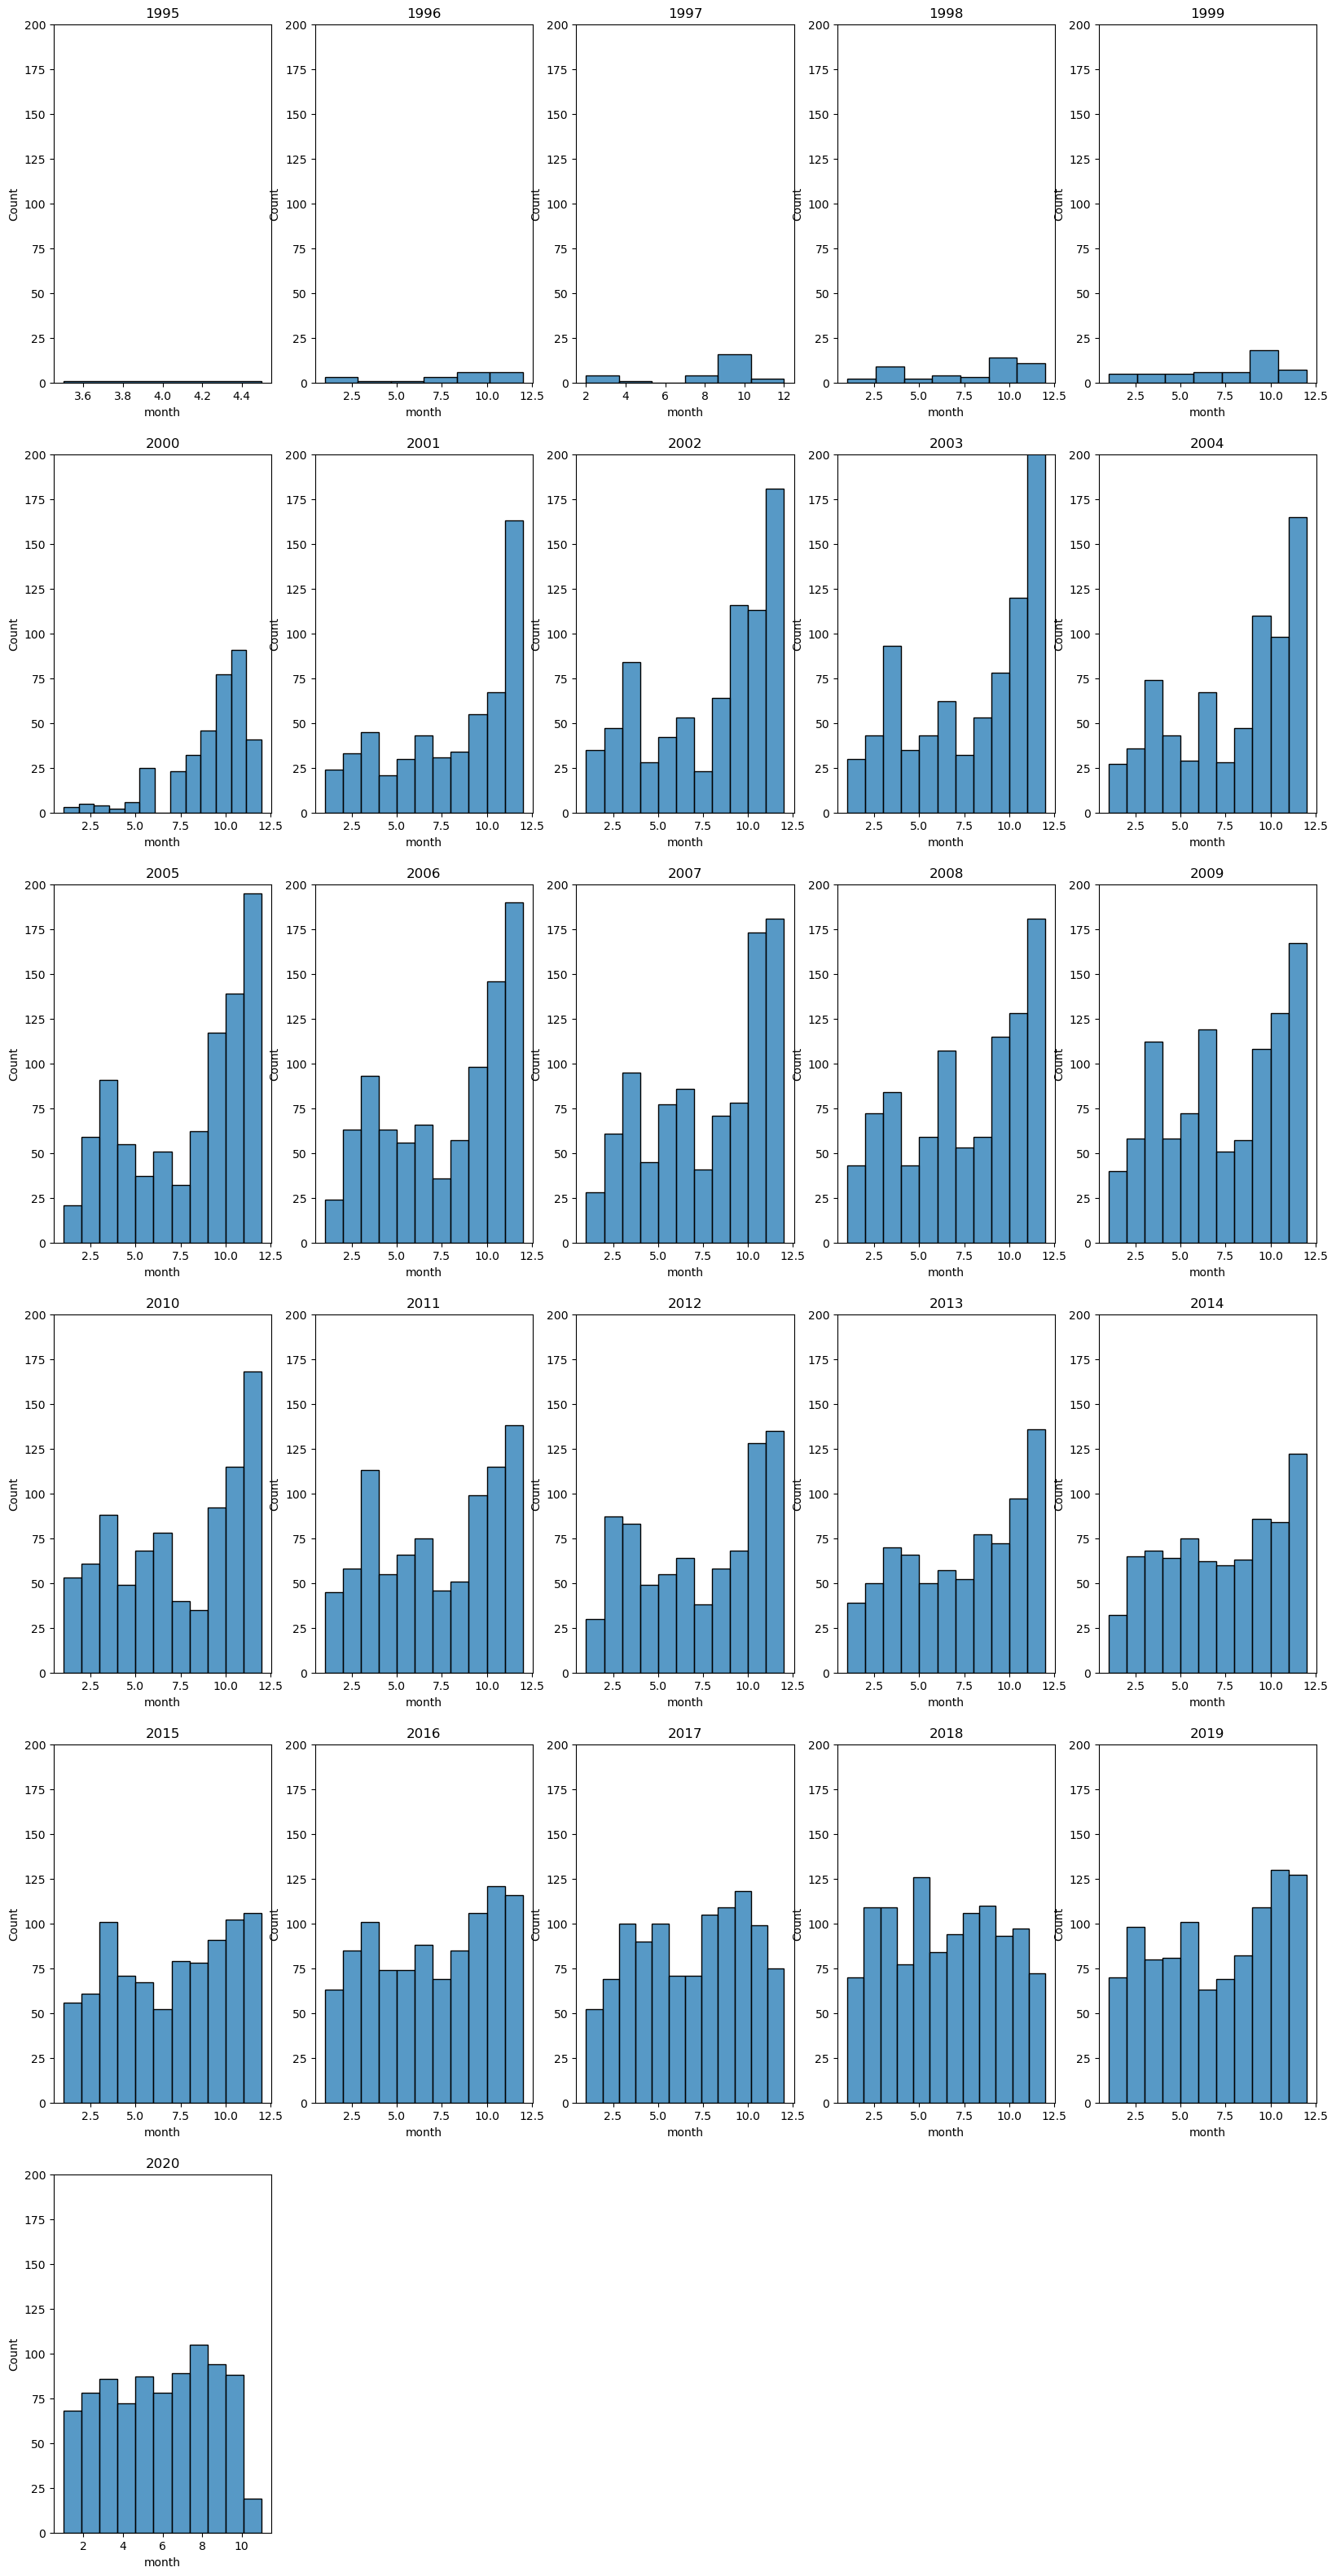

In [93]:
includedYears = np.sort(data_df.year.unique()) # get all the unique years
rws = round(np.ceil(len(includedYears)/5))
allmeans = []
fig = plt.figure(1,figsize=(20, 40))


for k in range(len(includedYears)):
    ax = fig.add_subplot(rws,5,k+1)
    sns.histplot(data=data_df[data_df.year == includedYears[k]], x='month')
    plt.ylim(0,200) #Make them all the same size for easier comparison
    plt.title(str(includedYears[k]))

plt.show()

In [119]:
monthly_df = pd.pivot_table(data_df, index = 'year', columns = 'month', values = 'score',  aggfunc = 'count').fillna(0)
monthly_df['total'] = monthly_df.sum(axis = 1)
monthly_df['end_percent'] = ((monthly_df[10] + monthly_df[11] + monthly_df[12])/ monthly_df['total']) * 100
monthly_df.head()



month,1,2,3,4,5,6,7,8,9,10,11,12,total,end_percent
year,,,,,,,,,,,,,,
1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
1996,1.0,2.0,1.0,0.0,0.0,1.0,1.0,2.0,4.0,2.0,3.0,3.0,20.0,40.000000
1997,0.0,3.0,1.0,0.0,1.0,0.0,2.0,2.0,7.0,9.0,1.0,1.0,27.0,40.740741
1998,2.0,0.0,6.0,3.0,2.0,2.0,2.0,3.0,5.0,9.0,9.0,2.0,45.0,44.444444
1999,2.0,3.0,3.0,2.0,5.0,4.0,2.0,6.0,10.0,8.0,4.0,3.0,52.0,28.846154


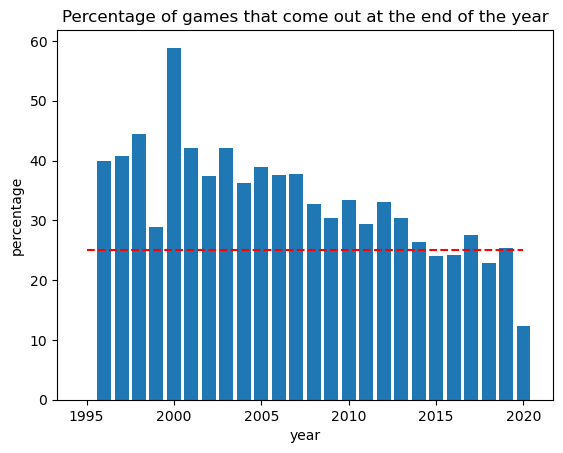

In [121]:
fig, ax = plt.subplots()

plt.bar(monthly_df.index, monthly_df['end_percent'])
plt.plot([monthly_df.index.min(), monthly_df.index.max()], [300/12, 300/12], linestyle = '--', color = 'red')
plt.xlabel('year')
plt.ylabel('percentage')
plt.title('Percentage of games that come out at the end of the year')
#plt.text(20, 100, 'mean score: ' + str(round(meanval)))
plt.show()

### How does the score distribution change by year

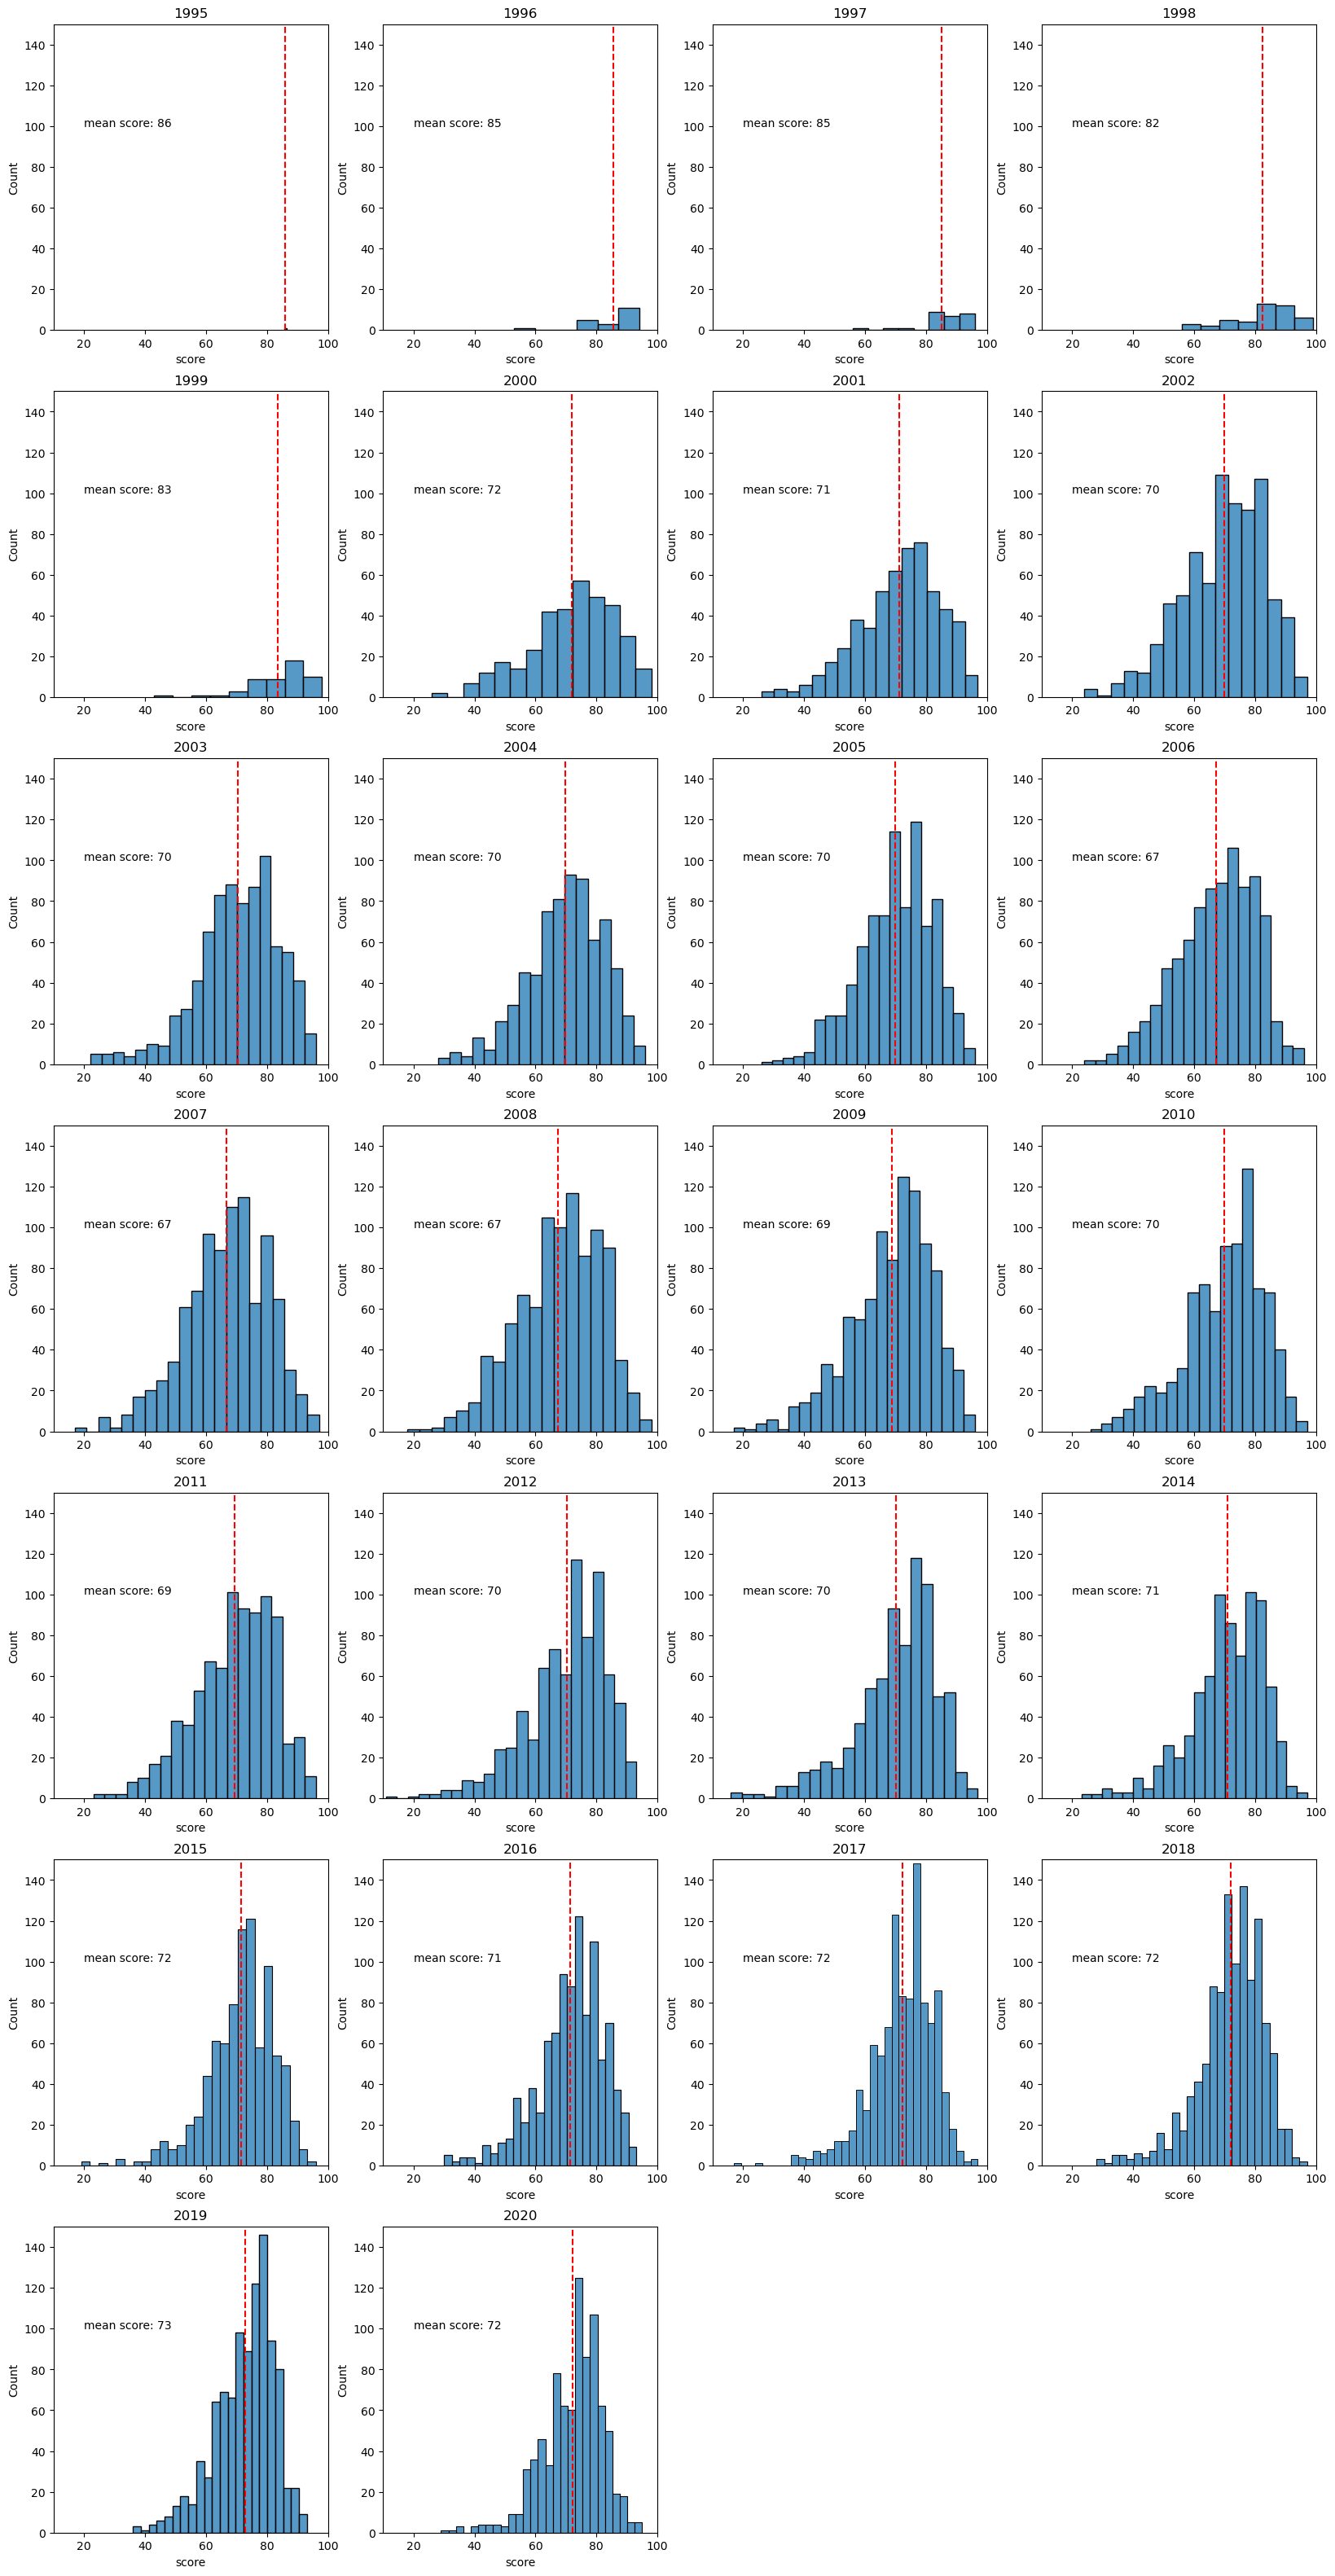

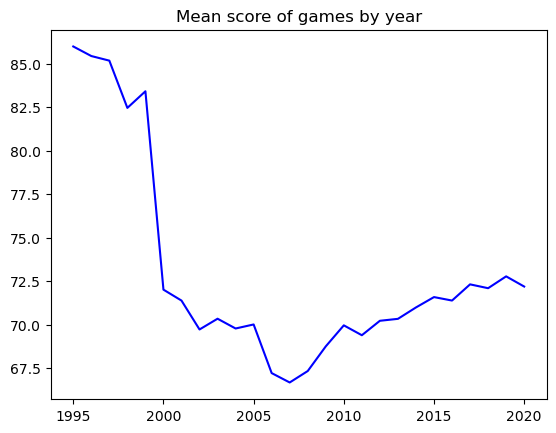

In [97]:
includedYears = np.sort(data_df.year.unique()) # get all the unique years
rws = round(np.ceil(len(includedYears)/4))
allmeans = []
fig = plt.figure(1,figsize=(20, 40))

# now loop through each year to draw a histogram of games
for k in range(len(includedYears)):
    ax = fig.add_subplot(rws,4,k+1)
    sns.histplot(data=data_df[data_df.year == includedYears[k]], x='score')
    # draw a line at the mean of the data
    meanval = data_df[data_df.year == includedYears[k]]['score'].mean()
    allmeans.append(meanval)
    plt.plot([meanval, meanval], [0, 150], linestyle = '--', color = 'red')
    plt.ylim(0,150) #Make them all the same size for easier comparison
    plt.xlim(10,100)
    plt.text(20, 100, 'mean score: ' + str(round(meanval)))
    plt.title(str(includedYears[k]))

plt.show()

# draw a plot of how the mean has changed over time
fig, ax = plt.subplots()
plt.plot(includedYears, allmeans, linestyle = '-', color = 'blue')
plt.title('Mean score of games by year')
plt.show()

## Extra: If you want to see how games are clustered here is an example

In [100]:

# get the titles from that developer
devnam = 'Nintendo'
names = data_df[data_df['developer'] == devnam]['name'].to_list()
platforms = data_df.platform.unique().tolist()

drawhuh = True
drawwind = (0,40)

clusters,unclustered = generate_clusters(names, platforms=platforms)

for i in range(len(clusters)):
    print('CLUSTER NUM:' + str(i))
    for b in clusters[i]:
        print(names[b])
print('UNCLUSTERED:')
for j in unclustered:
    print(names[j])


CLUSTER NUM:0
The Legend of Zelda: Ocarina of Time
The Legend of Zelda: Breath of the Wild
The Legend of Zelda: Breath of the Wild
The Legend of Zelda: Twilight Princess
The Legend of Zelda: The Wind Waker
The Legend of Zelda Collector's Edition
The Legend of Zelda: Majora's Mask
The Legend of Zelda: Twilight Princess
The Legend of Zelda: Skyward Sword
The Legend of Zelda: Ocarina of Time / Master Quest
The Legend of Zelda: A Link Between Worlds
The Legend of Zelda: Phantom Hourglass
The Legend of Zelda: Spirit Tracks
The Legend of Zelda: Four Swords Adventures
The Legend of Zelda: Breath of the Wild - The Champions' Ballad
The Legend of Zelda: Breath of the Wild - The Master Trials
The Legend of Zelda: Tri Force Heroes
CLUSTER NUM:1
Super Mario Galaxy
Super Mario Odyssey
Super Mario 64
Super Mario 3D World
Super Mario Sunshine
Super Mario 3D Land
Super Mario Maker
Super Mario Maker 2
Super Mario 64 DS
Super Mario Advance
Super Mario 3D All-Stars
Super Mario Bros. 35
Super Mario Maker 